In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load training and test data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")


In [6]:
# Extract IDs
test_ids = test_df["session_id"]

# Separate features and target
X_train = train_df.drop(columns=["attack_detected", "session_id"])
y_train = train_df["attack_detected"]
X_test = test_df.drop(columns=["session_id"])

# Detect categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()



In [8]:
# Custom feature selector for use inside pipeline
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, k=20):
        self.k = k
        self.selector = SelectKBest(score_func=f_classif, k=self.k)

    def fit(self, X, y=None):
        self.selector.fit(X, y)
        return self

    def transform(self, X):
        return self.selector.transform(X)

# Column Transformer (no changes)
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Pipeline with feature selection inside
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("feature_selection", SelectKBest(score_func=f_classif)),  # no k here yet
    ("classifier", RandomForestClassifier(random_state=42))
])

# Hyperparameter grid (try different feature counts + RF params)
param_grid = {
    "feature_selection__k": [5, 10, 15, "all"],
    "classifier__n_estimators": [100, 300, 500],
    "classifier__max_depth": [None, 10, 20, 50],
    "classifier__min_samples_split": [2, 5],
    "classifier__max_features": ["sqrt", "log2"]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy", verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Final predictions
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


In [6]:
submission = pd.DataFrame({
    "session_id": test_ids,
    "attack_detected": predictions
})

# Save to CSV
submission.to_csv("Priyanshu_solution.csv", index=False)
print("✅ Priyanshu_solution.csv saved!")



✅ Priyanshu_solution.csv saved!


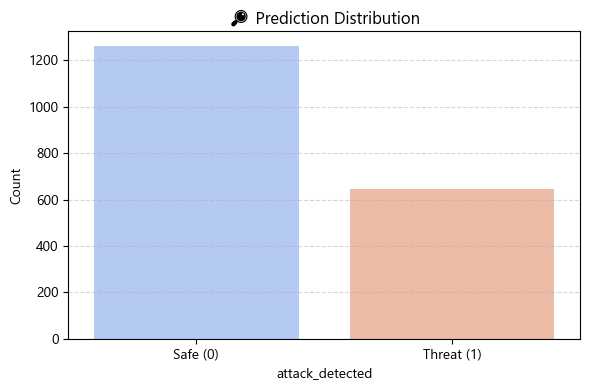

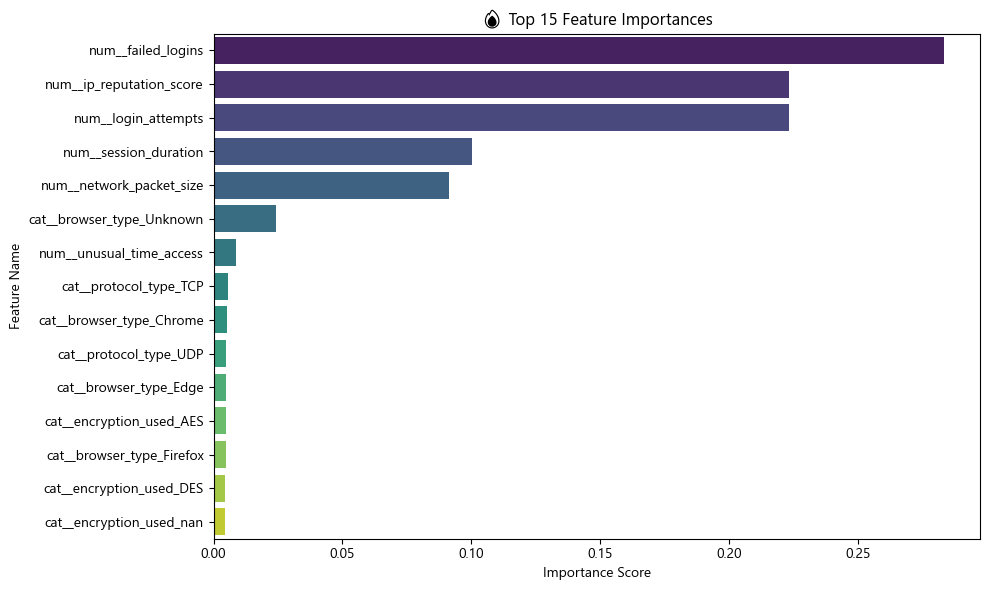

<Figure size 600x500 with 0 Axes>

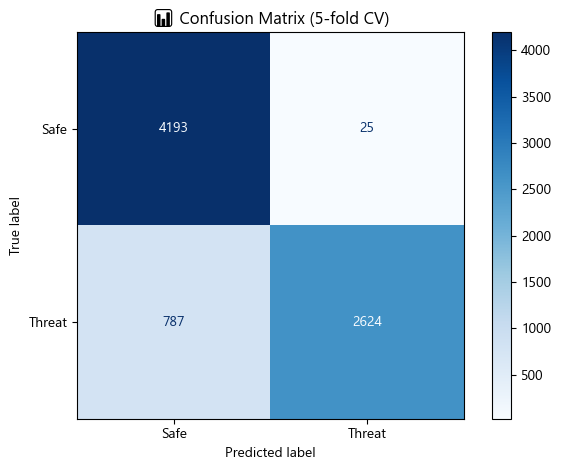

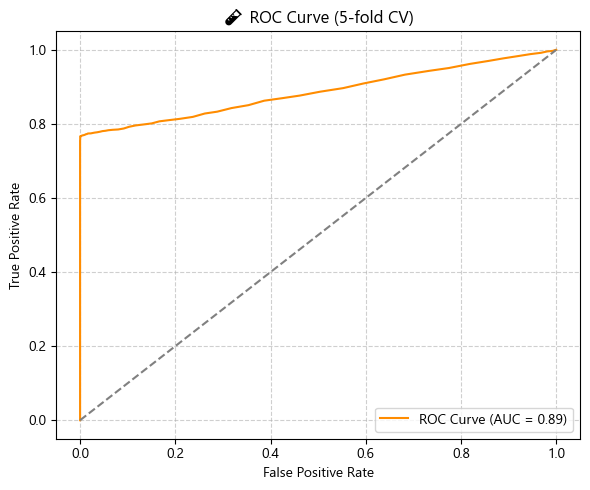

In [8]:
# ==================== 📊 VISUALIZATIONS ====================
# Set a font that supports emojis (Windows: Segoe UI Emoji, macOS: Apple Color Emoji)
plt.rcParams['font.family'] = 'Segoe UI Emoji'

# 1️⃣ Prediction Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=predictions, palette="coolwarm")
plt.title("🔎 Prediction Distribution")
plt.xlabel("attack_detected")
plt.ylabel("Count")
plt.xticks([0, 1], labels=["Safe (0)", "Threat (1)"])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 2️⃣ Feature Importances
# Fit preprocessing separately to get feature names
preprocessor.fit(X_train)
X_train_transformed = preprocessor.transform(X_train)
feature_names = preprocessor.get_feature_names_out()

# Get feature importances from model
rf_model = pipeline.named_steps['classifier']
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top 15
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][:15], y=feature_names[indices][:15], palette="viridis")
plt.title("🔥 Top 15 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

# 3️⃣ Confusion Matrix (on training set with cross-val predict)
y_pred_train = cross_val_predict(pipeline, X_train, y_train, cv=5)
cm = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Safe", "Threat"])
disp.plot(cmap="Blues", values_format="d")
plt.title("📊 Confusion Matrix (5-fold CV)")
plt.tight_layout()
plt.show()

# 4️⃣ ROC Curve
y_proba_train = cross_val_predict(pipeline, X_train, y_train, cv=5, method="predict_proba")[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_proba_train)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("🧪 ROC Curve (5-fold CV)")
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()